# 1. Environment settings

# 1.1 Install dependencies and setup

We need to install tensorflow.

<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
When installing tensorflow please make sure the it is listed in installed packages using commande pip list. 
</blockquote>

In [80]:
# import necessary packages 
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np

In [81]:
dataset_dir = 'dataset'

To avoid Out Of Memory (OOM) errors please execute the following sub-code for setting GPU Memory Consumption Growth 

In [82]:
gpus = tf.config.experimental.list_logical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

# 2 Data cleaning 

Let's see a random image quality 

Image size = (1080, 1920, 3)


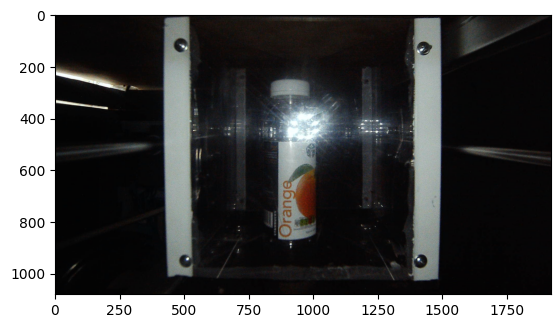

In [83]:
# plot an image 
img = cv2.imread(os.path.join(dataset_dir, 'Jus_bottles', 'WIN_20231207_10_08_58_Pro.jpg'))
print('Image size =', img.shape)

# convert image colors from BGR to RGB
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

## 2.1 Step 1 : remove all images of non compatible extension
accepted extensions 

In [84]:
image_extensions = ['.jpeg', '.jpg', '.png', '.bmp']

In [85]:
for image_class in os.listdir(dataset_dir):
    for image in os.listdir(os.path.join(dataset_dir, image_class)):
        image_path = os.path.join(dataset_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            _, tip = os.path.splitext(image_path)
            if tip not in image_extensions: 
                print('Image not in extension list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Error with image {}'.format(image_path))

## 2.2 Load data 
In this section we will use the tf.data.Dataset for image processing, for documentation about this tool, please execute the command: tf.data.Dataset??

<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
Please make sure that all your images file names contain only utf_8 caracters 
</blockquote>

In [86]:
data = tf.keras.utils.image_dataset_from_directory(dataset_dir)
 
# Extract class names
class_names = data.class_names

Found 800 files belonging to 4 classes.


In [87]:
# convert data into numpy iterator to access our data pipeline 
data_iterator = data.as_numpy_iterator()

#get another batch from iterator
batch = data_iterator.next()
# visulize one batch 
#batch[0]  # image represented as numpy array 
batch[1]  # labels 

array([1, 2, 2, 2, 2, 2, 2, 0, 3, 3, 2, 0, 2, 3, 2, 0, 2, 3, 2, 2, 2, 2,
       2, 3, 2, 2, 2, 0, 2, 2, 1, 2])

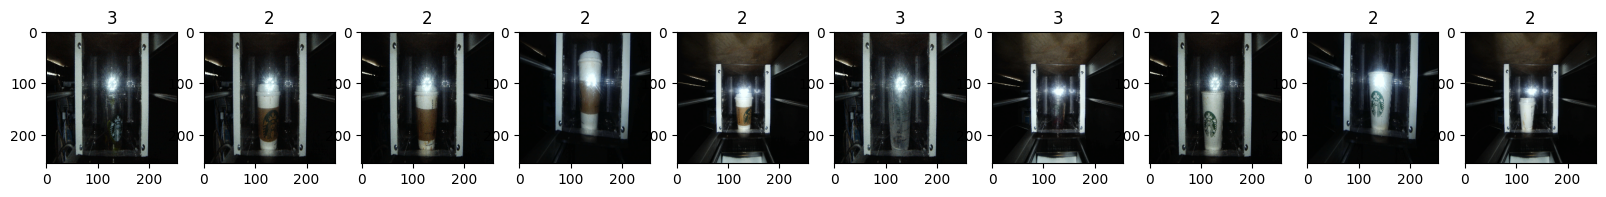

In [88]:
#get another batch from iterator
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

4 classes are identified: 

* 0: Empty 
* 1: jus_bottles
* 2: paper_cups  
* 3: plastic_cups

In [89]:
num_classes = len(class_names) # num_classes is the number of bottles categories
# Print and save class names to a file
print("Class Names:", class_names)

Class Names: ['Empty', 'jus_bottles', 'paper_cups', 'plastic_cups']


<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
So here we have our batch that contains our images and their corresponding labels. But the values are between 0 and 255. We want to optimiaze this values 
</blockquote>

## 2.2 Data pre-processing

### 2.2.1 Scale data 

we will transforme the values to smaller values to increse speed. (x value represents the image)

In [90]:
data = data.map(lambda x, y: (x / 255, tf.one_hot(tf.cast(y, tf.int32), depth=num_classes)))

scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

data values are now between 0 and 1. To make sure of this, let's print max and min values of data: 

In [91]:
print("Min value = ",data.as_numpy_iterator().next()[0].min()) 
print("Max value = ",data.as_numpy_iterator().next()[0].max()) 

Min value =  0.0
Max value =  1.0


Let's take a look at the images after scaling 

c:\Users\gbencheikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


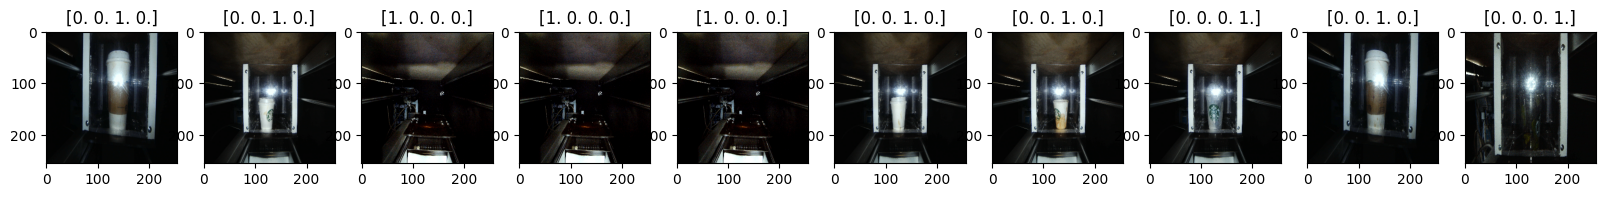

In [92]:
fig, ax = plt.subplots(ncols=10, figsize=(20,20))
for idx, img in enumerate(batch[0][:10]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### 2.2.2 Split data (training, validation and test)

In [93]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = len(data) - train_size - val_size

Make sure that the sum of variables is equal to data length

In [94]:
print("data lengeth =", len(data))
print("Parition is: ")
print("- train size=", train_size)
print("- validation size =", val_size)
print("- test size =", test_size)

if(train_size+ val_size+test_size != len(data)):
    print("Error: data spliting is not correctly done")
else: 
    print("Partition is good!, you can proceed.")

data lengeth = 25
Parition is: 
- train size= 17
- validation size = 5
- test size = 3
Partition is good!, you can proceed.


In [95]:
# split dataset
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

We will use data augmentation technique to artificially increase the size of our training dataset by applying various transformations to the existing images. This helps the model become more robust and generalize better.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
batch_size = 32

# Convert tf.data.Dataset to NumPy arrays
train_numpy = np.concatenate([x for x, y in train.as_numpy_iterator()], axis=0)
val_numpy = np.concatenate([x for x, y in val.as_numpy_iterator()], axis=0)

# Extract target data from the tf.data.Dataset
train_labels = np.concatenate([y for x, y in train.as_numpy_iterator()], axis=0)
val_labels = np.concatenate([y for x, y in val.as_numpy_iterator()], axis=0)

train_dataset = datagen_train.flow(train_numpy, train_labels, batch_size=batch_size)
val_dataset = datagen_train.flow(val_numpy, val_labels, batch_size=batch_size)

<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Summary</strong>
We have shuffeled and scaled our data. 

Data is devided into 3 classes: the two first classes are designed for trainning the deep learning model and the 3rd is for testing it.
</blockquote>

# 3. CNN model building 

## 3.1 Build deep leaning network

In [96]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

batch_size = 32 
# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Conv2D(batch_size, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D())

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization

model.add(Dense(num_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [97]:
model.compile('adam', loss='categorical_crossentropy', metrics = ['accuracy'])

Model summary

In [98]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 128)      

## 3.2 Train model

In [99]:
logdir  = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir) # to save the model, for checking and loging and monitore training process 

# Fit the model
hist = model.fit(train, 
                 epochs=20, 
                 validation_data=val, 
                 callbacks=[tensorboard_callback])

Epoch 1/20


17/17 [==============================] - 28s 2s/step - loss: 0.9022 - accuracy: 0.6746 - val_loss: 0.5218 - val_accuracy: 0.8250
Epoch 2/20
17/17 [==============================] - 26s 1s/step - loss: 0.5866 - accuracy: 0.7886 - val_loss: 0.5396 - val_accuracy: 0.8062
Epoch 3/20
17/17 [==============================] - 26s 1s/step - loss: 0.5431 - accuracy: 0.8107 - val_loss: 0.3349 - val_accuracy: 0.8188
Epoch 4/20
17/17 [==============================] - 26s 1s/step - loss: 0.3879 - accuracy: 0.8585 - val_loss: 0.1635 - val_accuracy: 0.9563
Epoch 5/20
17/17 [==============================] - 25s 1s/step - loss: 0.2269 - accuracy: 0.9210 - val_loss: 0.2157 - val_accuracy: 0.9375
Epoch 6/20
17/17 [==============================] - 24s 1s/step - loss: 0.2100 - accuracy: 0.9357 - val_loss: 0.0984 - val_accuracy: 0.9563
Epoch 7/20
17/17 [==============================] - 26s 1s/step - loss: 0.1558 - accuracy: 0.9467 - val_loss: 0.0572 - val_accuracy: 0.9812
Epoch 8/20
17/17 [=============

## 3.3 Plot performance

Loss function

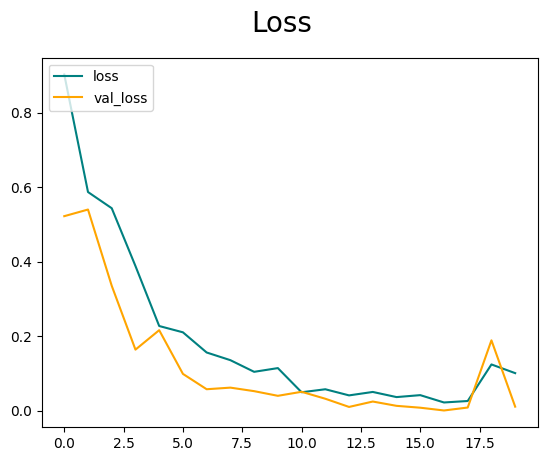

In [100]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

Accuracy function

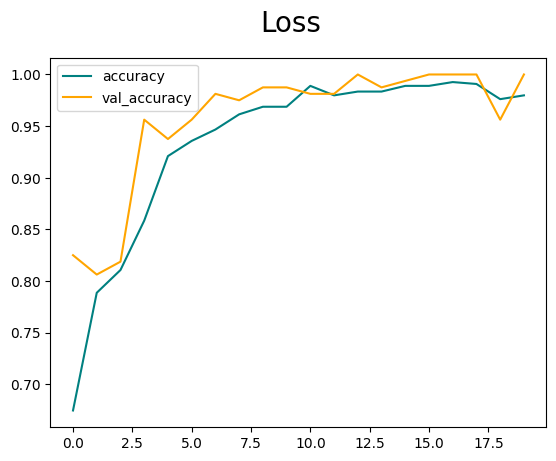

In [101]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 3.4 Evaluation 

In [102]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [103]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 259ms/step


In [104]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


## 3.5 Test 

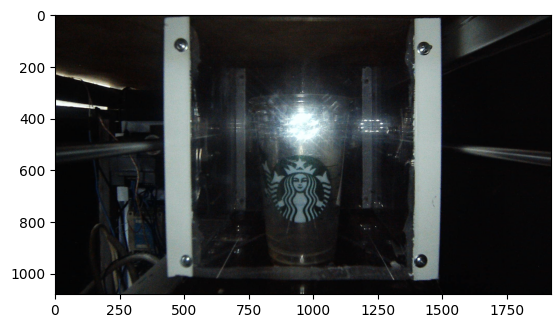

In [124]:
import cv2

img = cv2.imread('plastic_cup_test.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [125]:
resize = tf.image.resize(img, (256, 256))
np.expand_dims(resize, 0).shape
yhat = model.predict(np.expand_dims(resize/255, 0))
print("yhat=", yhat)

proba_threshold = 0.999999

# identify the predicted class which cooreponds to the highest predicted probability
predicted_class = np.argmax(yhat)

# Get the corresponding probability
predicted_probability = yhat[0, predicted_class]

# Check if the probability exceeds the threshold

data = tf.keras.utils.image_dataset_from_directory(dataset_dir) # for image batchinf and resizing and building our data pipeline

# Extract class names
class_names = data.class_names

print("Predicted Class: ", class_names[predicted_class])
print("Predicted Probability: ", predicted_probability)

1/1 [==============================] - 0s 34ms/step
yhat= [[1.9399646e-05 1.4857737e-03 2.3136153e-03 9.9618125e-01]]
Found 800 files belonging to 4 classes.
Predicted Class:  plastic_cups
Predicted Probability:  0.99618125


# 4. Save the model and corresponding labels

## 4.1 save the whole model
<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
This method saves the entire model, including the architecture, optimizer, and learned weights
</blockquote>

In [116]:
model.save('model.h5')
model.save('camera_code/Model/model.h5')
print("The model has been successfully saved.")

c:\Users\gbencheikh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


The model has been successfully saved.


## 4.3 Save model architecture to JSON file

<blockquote class="comment">
<strong style="text-decoration:underline;display:block">Note</strong>
This method saves only the model architecture without the weights or optimizer information
</blockquote>


In [108]:
# 
model_json = model.to_json()
with open('your_model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

print("The model has been succesfully saved into Json file")

The model has been succesfully saved into Json file


## 4.2 Save cooresponding labels

In [117]:
with open('labels.txt', 'w') as file:
    for id, class_name in enumerate(class_names):
        file.write(f"{id} {class_name}\n")
with open('camera_code/Model/labels.txt', 'w') as file:
    for id, class_name in enumerate(class_names):
        file.write(f"{id} {class_name}\n")